### Imports and preprocessing

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import typing
import os
import sys

from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive
from zipfile import ZipFile

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# truth
TRUTH_DATASET = 'ground_truth_color'

with ZipFile(f'/content/gdrive/MyDrive/{TRUTH_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{TRUTH_DATASET}')

# compressed
COMPRESSED_DATASET = 'compressed'

with ZipFile(f'/content/gdrive/MyDrive/{COMPRESSED_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{COMPRESSED_DATASET}')

# restored AR-CNN
ARCNN_DATASET = 'results_ARCNN'

with ZipFile(f'/content/gdrive/MyDrive/{ARCNN_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{ARCNN_DATASET}')

# restored FBCNN
FBCNN_DATASET = 'results_FBCNN'

with ZipFile(f'/content/gdrive/MyDrive/{FBCNN_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{FBCNN_DATASET}')

# restored DNCNN3
DNCNN_DATASET = 'results_DNCNN3'

with ZipFile(f'/content/gdrive/MyDrive/{DNCNN_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{DNCNN_DATASET}')

#### functions

In [18]:
# functions for matching two pictures

def set_index_and_coordinates(kp, des):
    index_dict = {}
    for i, point in enumerate(kp):
        if (kp[i], des[i], kp[i].pt) not in index_dict.values():
            index_dict[i] = (kp[i], des[i], kp[i].pt)
    return index_dict

def dist(v1, v2, dist_type: str):
    """
    in case of dist_type = 'vec':
        calculate euclidean distance between descroptors vectors
    in case of dist_type = 'kp':
        calculate diameter of the meaningful keypoint neighborhood for each kp1, kp2
    in case of dist_type = 'coord':
        calculate euclidean distance between coordinates
    """
    if dist_type == 'vec':
        summ = 0
        for i in range(len(v1)):
            summ += (v1[i] - v2[i])**2
        return math.sqrt(summ)

    if dist_type == 'kp':
        return abs(v1.size - v2.size)

    if dist_type == 'coord':
        summ = 0
        for i in range(len(v1)):
            summ += (v1[i] - v2[i])**2
        return math.sqrt(summ)

def get_matches(kp_idx1: dict, kp_idx2: dict, radius = 1.0):
    """
    get simple matches for two dict of coordinates of features of images
    """
    matches = {}
    for k1,v1 in kp_idx1.items():
        for k2, v2 in kp_idx2.items():
            if dist(v1[2], v2[2], dist_type='coord') < radius:
                if k1 in matches:
                    # if need distnace to be 'kp' - switch dist_type and also [1] -> [0]
                    if dist(kp_idx1[k1][1], v2[1], dist_type='vec') > dist(v1[1], v2[1], dist_type='vec'):
                        matches[k1] = k2
                else:
                    matches[k1] = k2
    return matches

def get_cross_matches(matches1, matches2):
    """
    calculate cross match features
    """
    cross_matches = {}
    for k1, v1 in matches1.items():
        if k1 in matches2.values():
            if matches2[v1] == k1:
                cross_matches[k1] = v1
    return cross_matches

def coordinates_match(img1, img2, radius = 1, cross_match = False):
    """
    SIFT calculated features
    feature matching using euclidean proximity
    """
    print('images shape:', img1.shape)
    matches_dict = {}

    # SIFT feature detector
    sift = cv2.xfeatures2d.SIFT_create()
    kp_im1, des_im1 = sift.detectAndCompute(img1, None)
    kp_im2, des_im2 = sift.detectAndCompute(img2, None)

    # get coordinates of features and set index
    idx_im1 = set_index_and_coordinates(kp_im1, des_im1)
    idx_im2 = set_index_and_coordinates(kp_im2, des_im2)

    print('radius value:', radius)
    print('number of features for img1:', len(idx_im1))
    print('number of features for img2:', len(idx_im2))

    if not cross_match:
        # simple match
        im1_VS_im2_match = get_matches(idx_im1, idx_im2, radius = radius)
        # result
        for k1, k2 in im1_VS_im2_match:
            matches_dict[idx_im1[k1]] = idx_im2[k2]

        print('number of matching:', len(matches_dict))

    if cross_match:
        # simple match
        im1_VS_im2_match = get_matches(idx_im1, idx_im2, radius = radius)
        im2_VS_im1_match = get_matches(idx_im2, idx_im1, radius = radius)
        # cross_match
        cross_matches = get_cross_matches(im1_VS_im2_match, im2_VS_im1_match)
        # result
        for k1, k2 in cross_matches.items():
            matches_dict[idx_im1[k1][2]] = idx_im2[k2][2]
        
        cross_match_value = len(matches_dict)/len(idx_im2)

        print('number of img1 VS img2 matching:', len(im1_VS_im2_match))
        print('number of img2 VS img1 matching:', len(im2_VS_im1_match))
        print('cross match value:', len(matches_dict)/len(idx_im2))

    return matches_dict, cross_match_value

In [20]:
# functions for batch matching

def get_list_with_path(folder_path):
    '''
    input: path to folder with images
    output: list with path to images in folder
    '''
    path_list = []
    for image in os.listdir(folder_path):
        path_list.append(folder_path + '/' + image)
    return sorted(path_list)

def coordinates_batch_match(pack1_path, pack2_path, radius = 1, cross_match = False):
    '''
    coordinates based match for package

    input: path to folder with images
    output: list with match values
    '''
    match_values = []
    pack1_images = get_list_with_path(pack1_path)
    pack2_images = get_list_with_path(pack2_path)
    for i in range(len(pack1_images)):
        img1 = cv2.imread(pack1_images[i])
        img2 = cv2.imread(pack2_images[i])
        print('#'*50)
        print('image', i)
        print()
        matches, value = coordinates_match(img1, img2, radius = radius, cross_match=cross_match)
        print()
        match_values.append(value)
    return match_values

## metric

#### experiment with one image

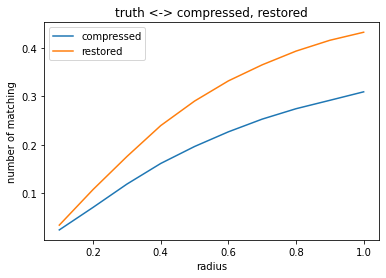

In [ ]:
logg_path = 'logg.txt'
with open(logg_path, 'w+') as file:
    pass
try:
    sys.stdout = open(logg_path, "w")

    num_matches_comp = []
    num_matches_rest = []

    # matching
    x = np.arange(0.1, 1.1, 0.1)
    for r in x:
        print('#'*50)
        print('truth and compressed matching:')
        print()
        tr_comp_coord_matches, tr_comp_value = coordinates_match(tr, comp, radius = r, cross_match=True)
        print()
        print()
        print('truth and restored matching:')
        print()
        tr_rest_coord_matches, tr_rest_value = coordinates_match(tr, rest, radius = r, cross_match=True)

        num_matches_comp.append(tr_comp_value)
        num_matches_rest.append(tr_rest_value)

    # plot number of matches
    plt.figure(1)
    plt.xlabel('radius')
    plt.ylabel('number of matching')
    plt.title('truth <-> compressed, restored')
    y1 = num_matches_comp
    y2 = num_matches_rest
    plt.plot(x, y1, label = 'compressed')
    plt.plot(x, y2, label = 'restored')
    plt.legend()

finally:
    sys.stdout.close()  
    sys.stdout = sys.__stdout__

In [ ]:
files.download('logg.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### calculate metric for AR-CNN, FBCNN, DNCNN3

In [ ]:
%%time

# AR-CNN
arcnn_values = coordinates_batch_match('/content/ground_truth_color', 
                                       '/content/results_ARCNN', 
                                       radius = 1, cross_match=True)
print(arcnn_values)

##################################################
image 0

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 12971
number of features for img2: 10878
number of img1 VS img2 matching: 5931
number of img2 VS img1 matching: 5888
cross match value: 0.43307593307593306

##################################################
image 1

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 13120
number of features for img2: 10928
number of img1 VS img2 matching: 5926
number of img2 VS img1 matching: 5893
cross match value: 0.4315519765739385

##################################################
image 2

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 13076
number of features for img2: 10897
number of img1 VS img2 matching: 5903
number of img2 VS img1 matching: 5933
cross match value: 0.43002661282921906

##################################################
image 3

images shape: (1536, 2048, 3)
radius value: 1
number of features 

### histogram/distribution plot

In [ ]:
def hist_coord_dist(matches: dict, eps = 2, bins = 20):
    """
    input: {(x11, y11): (x12, y12), ...}
    output: histogram/distribution plot
    """
    distance_data = []
    for coord1, coord2 in matches.items():
        distance_data.append(round(dist(coord1, coord2, 'coord'), eps))
    data = pd.DataFrame({'Distance': distance_data})

    sns.displot(data, bins = bins)
    plt.show()
    return data

coordinate distance between matching features in 1 pixel radius

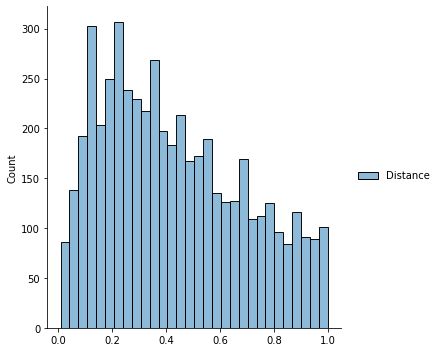

In [ ]:
# truth <-> compressed 
distance_data = []
for coord1, coord2 in tr_comp_coord_matches.items():
    distance_data.append(round(dist(coord1, coord2, 'coord'), 4))
data = pd.DataFrame({'Distance': distance_data})

sns.displot(data, bins = 30)
plt.show()

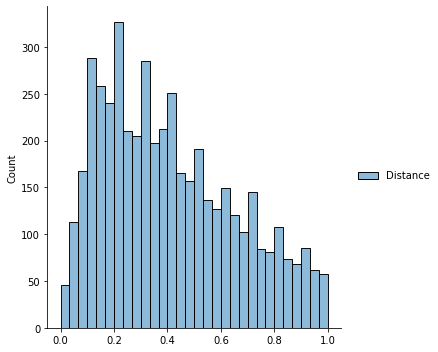

In [ ]:
# truth <-> compressed 
distance_data = []
for coord1, coord2 in tr_rest_coord_matches.items():
    distance_data.append(round(dist(coord1, coord2, 'coord'), 4))
data = pd.DataFrame({'Distance': distance_data})

sns.displot(data, bins = 30)
plt.show()

descriptors distance between matching features in 1 pixel radius

### batch metric

In [15]:
cv2.imread('/content/compressed/0000000000_compressed.jpg')

array([[[ 88,  88,  88],
        [ 88,  88,  88],
        [ 88,  88,  88],
        ...,
        [ 58,  58,  58],
        [ 58,  58,  58],
        [ 58,  58,  58]],

       [[ 88,  88,  88],
        [ 88,  88,  88],
        [ 88,  88,  88],
        ...,
        [ 58,  58,  58],
        [ 58,  58,  58],
        [ 58,  58,  58]],

       [[ 88,  88,  88],
        [ 88,  88,  88],
        [ 88,  88,  88],
        ...,
        [ 58,  58,  58],
        [ 58,  58,  58],
        [ 58,  58,  58]],

       ...,

       [[108, 108, 108],
        [110, 110, 110],
        [113, 113, 113],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 18,  18,  18]],

       [[108, 108, 108],
        [110, 110, 110],
        [113, 113, 113],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 18,  18,  18]],

       [[108, 108, 108],
        [110, 110, 110],
        [113, 113, 113],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 18,  18,  18]]